In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
from keras_cv import utils
from keras_cv.layers import BaseImageAugmentationLayer
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2022-10-18 22:12:06.179416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:06.210246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:06.210371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
ds_train = image_dataset_from_directory(
'tiny_imagenet/train',
image_size=(64,64),
batch_size=32)

Found 100000 files belonging to 200 classes.


2022-10-18 22:12:10.978907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:10.979072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:10.979160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:11.482512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:12:11.482632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
ds_val = image_dataset_from_directory(
'tiny_imagenet/val',
image_size=(64,64),
batch_size=32)

Found 10000 files belonging to 200 classes.


In [5]:
class RandomBlend(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint randomly applies a blue tint to images.

    Args:
      value_range: value_range: a tuple or a list of two elements. The first value
        represents the lower bound for values in passed images, the second represents
        the upper bound. Images passed to the layer should have values within
        `value_range`.
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is blue shifted. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and a fully blue image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
    """

    def __init__(self, value_range, factor, **kwargs):
        super().__init__(**kwargs)
        self.value_range = value_range
        self.factor = utils.parse_factor(factor)
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor() 

    def augment_image(self, image, transformation=None, **kwargs):
        image = utils.transform_value_range(image, self.value_range, (0, 1))
        print("Here is the transformation:",transformation)
        multOrScreen = (np.random.randint(2))
        print(multOrScreen)
        
        if(multOrScreen==0):
            augImg = image * image
            augImg = augImg * image
            
        else:
            augImg = 1 - (1 - image) * (1 - image)
            augImg = 1 - (1 - augImg) * (1 - image)
            

        image = (augImg * transformation) + (image * (1-transformation))
        image = tf.clip_by_value(image, 0.0, 1.0)
        # result = utils.transform_value_range(result, self.value_range, (0, 255))
        
        return image

    def augment_label(self, label, transformation=None, **kwargs):
        return label

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # you can also perform no-op augmentations on label types to support them in
        # your pipeline.
        return bounding_boxes

In [6]:
augmenter = keras_cv.layers.Augmenter(
  layers=[
      # keras.layers.Rescaling(scale=1./255),
      keras_cv.layers.RandomFlip(),
      # keras.layers.RandomTranslation(height_factor=0.2,width_factor=0.2),
      RandomBlend(value_range=(0, 1), factor=(0.01, 1.0)),
      # keras_cv.layers.RandAugment(value_range=(0, 255)),
      # keras_cv.layers.CutMix(),
      # keras_cv.layers.MixUp()
    ]
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

def augment_data(images, labels):
  inputs = {"images": images, "labels": labels}
  outputs = augmenter(inputs)
  return outputs['images'], outputs['labels']


def label_one_hot(images, labels):
  labels = tf.one_hot(labels, 200)
  outputs = {"images": images, "labels": labels}
  return outputs['images'], outputs['labels']

In [7]:
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))

In [8]:
ds_val = ds_val.map(lambda x, y: (normalization_layer(x), y))

In [9]:
ds_train = ds_train.map(label_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(label_one_hot, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
ds_train = ds_train.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

Here is the transformation: Tensor("augmenter/random_blend/map/while/random_uniform:0", shape=(), dtype=float32)
0


In [ ]:
inputs = keras.Input(shape=(64,64,3))
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32,64,128,256,512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(200, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

In [12]:
opt = tf.optimizers.Adam(learning_rate=0.0001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy', 'TopKCategoricalAccuracy']
)

In [ ]:
history = model.fit(ds_train, batch_size=32,validation_data=ds_val, epochs=30)

In [ ]:
history2 = model.fit(ds_train, batch_size=32,validation_data=ds_val, epochs=30)

In [11]:
opt = tf.optimizers.SGD(momentum=0.9),

model = keras_cv.models.DenseNet121(
    include_rescaling=False, include_top=True, classes=200)
    
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.SGD(momentum=0.9),
    metrics=["accuracy", "top_k_categorical_accuracy"],
)

In [16]:

history = model.fit(
    ds_train,
    epochs=50,
    batch_size=32,
    validation_data=ds_val,
)

Epoch 1/50
3125/3125 [==============================] - 108s 34ms/step - loss: 0.4006 - accuracy: 0.8765 - top_k_categorical_accuracy: 0.9872 - val_loss: 3.7308 - val_accuracy: 0.4138 - val_top_k_categorical_accuracy: 0.6709
Epoch 2/50
3125/3125 [==============================] - 107s 34ms/step - loss: 0.3884 - accuracy: 0.8795 - top_k_categorical_accuracy: 0.9878 - val_loss: 3.7227 - val_accuracy: 0.4178 - val_top_k_categorical_accuracy: 0.6716
Epoch 3/50
3125/3125 [==============================] - 108s 35ms/step - loss: 0.3733 - accuracy: 0.8849 - top_k_categorical_accuracy: 0.9889 - val_loss: 3.8530 - val_accuracy: 0.4097 - val_top_k_categorical_accuracy: 0.6657
Epoch 4/50
3125/3125 [==============================] - 110s 35ms/step - loss: 0.3582 - accuracy: 0.8874 - top_k_categorical_accuracy: 0.9898 - val_loss: 3.8062 - val_accuracy: 0.4092 - val_top_k_categorical_accuracy: 0.6677
Epoch 5/50
3125/3125 [==============================] - 106s 34ms/step - loss: 0.3468 - accuracy: 0.

In [17]:
np.save('tinyimagenet_densenet121_flip_blend_epoch_50_100.npy',history.history)

In [18]:
model.save('tiny_imagenet_flip_blend_densenet_epoch_50_100')

INFO:tensorflow:Assets written to: tiny_imagenet_flip_blend_densenet_epoch_50_100/assets


INFO:tensorflow:Assets written to: tiny_imagenet_flip_blend_densenet_epoch_50_100/assets


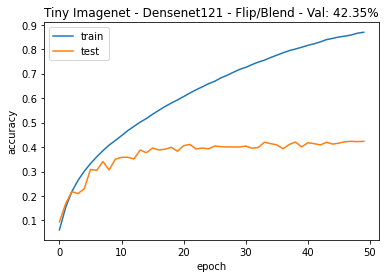

In [15]:
# Train/Test Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Tiny Imagenet - Densenet121 - Flip/Blend - Val: 42.35%')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('tiny_imagenet_flip_blend_densenet.pdf')
plt.show()